In [17]:
from sklearn.datasets import fetch_openml
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import numpy as np

from normflows import config, nn_models, transformations, distributions

%matplotlib inline

In [18]:
rs = np.random.RandomState(101)

In [50]:
K = 1
dim_z = 40
dim_x = 28 * 28
width = 64
n_hidden = 3
activation_fn = transformations.relu
activation_fn_type = 'relu'

encoder_architecture = {
    'width': width,
    'hidden_layers': n_hidden,
    'input_dim': dim_x,
    'output_dim': 2 * dim_z + 2 * dim_z * K + 1 * K,
    'activation_fn_type': activation_fn_type,
    'activation_fn_params': '',
    'activation_fn': activation_fn
}
decoder_architecture = {
    'width': width,
    'hidden_layers': n_hidden,
    'input_dim': dim_z,
    'output_dim': dim_x,
    'activation_fn_type': activation_fn_type,
    'activation_fn_params': '',
    'activation_fn': activation_fn,
    'output_activation_fn': transformations.sigmoid
}

encoder = nn_models.Feedforward(architecture=encoder_architecture)
decoder = nn_models.Feedforward(architecture=decoder_architecture)

keep_digits = [0, 1, 4, 7]

## Effect of flow length on reconstruction

In [54]:
def load_data():
    X, y = loadlocal_mnist(
        images_path=str(config.mnist / 't10k-images-idx3-ubyte'),
        labels_path=str(config.mnist / 't10k-labels-idx1-ubyte'))

    keep_idx = np.isin(y, keep_digits)
    X = X[keep_idx]
    y = y[keep_idx]
    X = X / 255
    X = (X >= 0.5).astype(int)  # Binarizing
    return X, y

def sample_from_prior_z(i, j):
    grid_dims = np.random.randn(dim_z) + np.array([i, j])
#     res = np.insert(np.zeros(dim_z - 2), 0, grid_dims)
    return grid_dims

def decode(theta, z):
    logits = decoder.forward(theta.reshape(1, -1), z.reshape(dim_z, -1)).T
    xhat = np.random.binomial(1, logits)
    im_recon = xhat.reshape(28, 28)
    return im_recon

def encode(phi, encoder, X, K, n_samples=100):
    N = X.shape[0]
    latent_params = encoder.forward(phi.reshape(1, -1), X.T)[0]
    mu0 = latent_params[:dim_z].reshape(N, dim_z)
    log_sigma_diag0 = latent_params[dim_z:2 * dim_z].reshape(N, dim_z)
    W = latent_params[2 * dim_z:2 * dim_z + K * dim_z].reshape(K, N, dim_z)
    U = latent_params[2 * dim_z + K * dim_z:2 * dim_z + 2 * K * dim_z].reshape(K, N, dim_z)
    b = latent_params[-K:].reshape(K, N)
    samples = []
    for _ in range(n_samples):
        samples.append(distributions.sample_from_pz(mu0, log_sigma_diag0, W, U, b, K))
    return np.vstack(samples)

def encode_decode(phi, theta, k, encoder, x):
    z = encode(phi, encoder, X, k, n_samples=1)
    x_recon = decode(theta, z)
    return x_recon

In [55]:
X, y = load_data()

In [56]:
sample_ims = []
for i in keep_digits:
    Xi = X[y == i]
    sample_ims.append(Xi[np.random.choice(np.arange(Xi.shape[0]))].reshape(28, 28))

In [59]:
flow_lengths = [1, 2, 4, 8, 16]
params = []
for K in flow_lengths:
    inner_dict = dict(K=K)
    phi = np.load((config.models / 'mnist' / f'weights_phi_{K}.npy').open('rb'))
    theta = np.load((config.models / 'mnist' / f'weights_phi_{K}.npy').open('rb'))

    inner_dict.update(phi=phi, theta=theta)
    
    encoder_architecture['output_dim'] = 2 * dim_z + 2 * dim_z * K + 1 * K
    inner_dict['encoder'] = nn_models.Feedforward(architecture=encoder_architecture, random=rs)
    params.append(inner_dict)

In [60]:
recon_ims = []
for i in range(10):
    digit_i = []
    for flow_dict in params:
        k = flow_dict['K']
        phi = flow_dict['phi']
        theta = flow_dict['theta']
        encoder = flow_dict['encoder']
        
        xhat = encode_decode(phi, theta, k, encoder, sample_ims[i])
        digit_i.append(xhat)
    recon_ims.append(digit_i)

AssertionError: Incorrect input shape (1, 69025)

In [ ]:
fig, axs = plt.subplots(ncols=len(flow_lengths), nrows=10, figsize=(len(flow_lengths) * 2.5, 10 * 2.5))
for i, (orig, recons) in enumerate(zip(sample_ims, recon_ims)):
    axs[i, 0].imshow(orig, cmap='gray')
    for j, (k, recon) in enumerate(zip(flow_lengths, recons)):
        axs[i, j+1].imshow(recon, cmap='gray')

## Flexibility of variational distribution

In [ ]:
latent_dists = []
for i in range(10):
    digit_i = []
    for flow_dict in params:
        k = flow_dict['K']
        phi = flow_dict['phi']
        theta = flow_dict['theta']
        encoder = flow_dict['encoder']
        
        zz = encode(phi, encoder, sample_ims[i], k, n_samples=5000)
        digit_i.append(zz)
    recon_ims.append(digit_i)

In [ ]:
fig, axs = plt.subplots(ncols=len(flow_lengths), nrows=10, figsize=(len(flow_lengths) * 2.5, 10 * 2.5))
for i, (orig, latent_dist) in enumerate(zip(sample_ims, latent_dists)):
    axs[i, 0].imshow(orig, cmap='gray')
    for j, (k, zz) in enumerate(zip(flow_lengths, latents)):
        axs[i, j+1].hist2d(zz[:, 0], zz[:, 1], bins=100)
        axs[i, j+1].set_title(f'K={k}')

## Mapping latent space

In [ ]:
xmin, xmax = -20, 20
ymin, ymax = -20, 20
grid = (40, 40)
all_ims = np.zeros((28 * grid[0], 28 * grid[1]))
for row, i in enumerate(np.linspace(xmin, xmax, grid[0])):
    for col, j in enumerate(np.linspace(ymin, ymax, grid[1])):
        z = sample_from_prior_z(i, j)
        im_recon = decode(z)
        all_ims[28 * row:28 * (row + 1), 28 * col:28 * (col + 1)] = im_recon

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(all_ims, cmap='gray')

## Effect of flow length on variational bound

In [61]:
free_energy_bounds = []
with (config.results / 'free_energy.txt').open('r') as f:
    for line in f:
        flow_length, free_energy_bound = line.split(': ')
        flow_length = int(flow_length.split(' ')[0])
        free_energy_bound = float(free_energy_bound)
        free_energy_bounds.append((flow_length, free_energy_bound))
        
free_energy_bounds = np.vstack(free_energy_bounds)

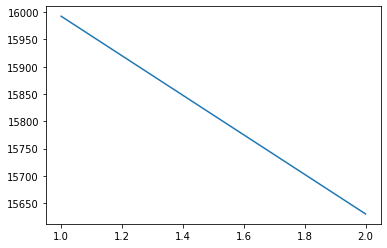

In [62]:
plt.plot(free_energy_bounds[:, 0], free_energy_bounds[:, 1])
plt.show()

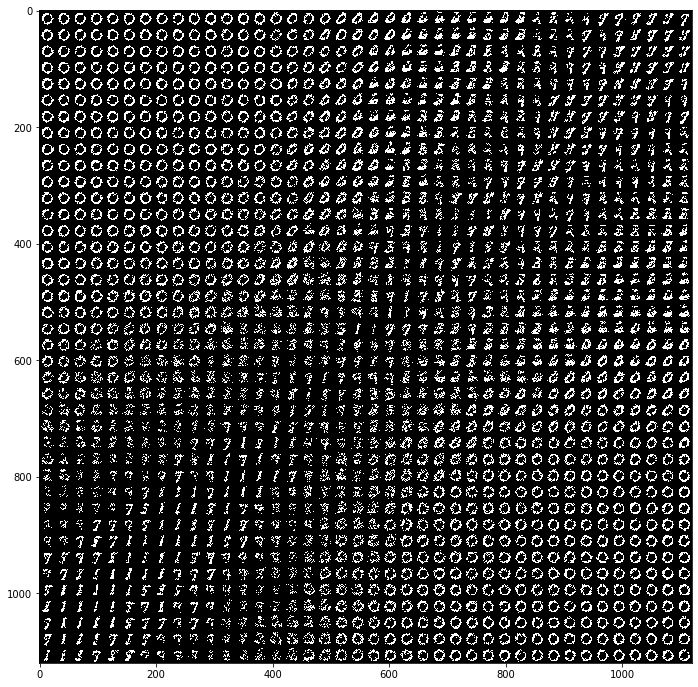

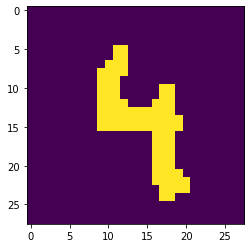

In [233]:
plt.imshow(sample_4)

In [234]:
def encode(weights, X, n_samples=100):
    N = X.shape[0]
    phi = encoder.forward(weights.reshape(1, -1), X.T)[0]
    mu0 = phi[:dim_z].reshape(N, dim_z)
    log_sigma_diag0 = phi[dim_z:2 * dim_z].reshape(N, dim_z)
    W = phi[2 * dim_z:2 * dim_z + K * dim_z].reshape(K, N, dim_z)
    U = phi[2 * dim_z + K * dim_z:2 * dim_z + 2 * K * dim_z].reshape(K, N, dim_z)
    b = phi[-K:].reshape(K, N)
    samples = []
    for _ in range(n_samples):
        samples.append(distributions.sample_from_pz(mu0, log_sigma_diag0, W, U, b, K))
    return np.vstack(samples)

In [235]:
z1 = encode(phi, sample_1.reshape(1, -1), n_samples=5000)
z4 = encode(phi, sample_4.reshape(1, -1), n_samples=5000)

In [191]:
z = np.vstack((z1, z4))
z.shape

(10000, 2)

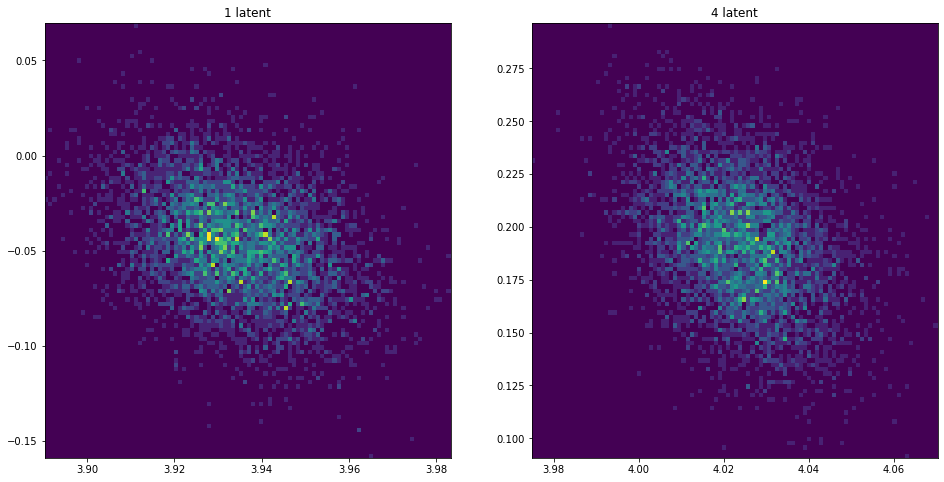

In [198]:
fix, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].hist2d(z1[:, 0], z1[:, 1], bins=100)
axs[1].hist2d(z4[:, 0], z4[:, 1], bins=100)
axs[0].set_title("1 latent")
axs[1].set_title("4 latent")
plt.show()

In [240]:
zz = encode(phi, sample_4.reshape(1, -1), n_samples=1)
xx = decode(zz)

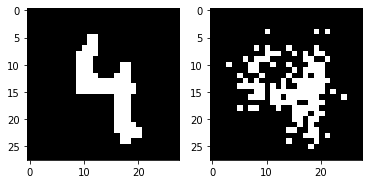

In [243]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(sample_4.reshape(28, 28), cmap='gray')
axs[1].imshow(xx.reshape(28, 28), cmap='gray')
plt.show()